In [11]:
import pandas as pd

## Azbestos dataset prep

In [12]:
csv_azbest = 'baza_gminy_azbest_2016-10-21.csv'
dfa = pd.read_csv(csv_azbest, encoding='utf-8', dtype={'TERYT': object})
dfa.head()

,Ilosc unieszkodliwiona [kg],Ilosc zinwentaryzowana [kg],Nazwa Gminy,Pozostala do unieszkodliwienia [kg],TERYT
0,0.0,414422.21,Bolesławiec,414422.21,020101
1,260850.0,1370092.75,Bolesławiec,1109242.75,020102
2,137176.6,409703.14,Gromadka,272526.54,020103
3,2178.0,473447.95,Nowogrodziec,471269.95,020104
4,3344.0,375537.64,Osiecznica,372193.64,020105


Translate header:

In [13]:
dfa.rename(columns={'Ilosc unieszkodliwiona [kg]': 'Disposed [kg]',
                    'Ilosc zinwentaryzowana [kg]': 'Inventory [kg]',
                   'Nazwa Gminy': 'Place Name'}, inplace=True)
dfa.head()

,Disposed [kg],Inventory [kg],Place Name,Pozostala do unieszkodliwienia [kg],TERYT
0,0.0,414422.21,Bolesławiec,414422.21,020101
1,260850.0,1370092.75,Bolesławiec,1109242.75,020102
2,137176.6,409703.14,Gromadka,272526.54,020103
3,2178.0,473447.95,Nowogrodziec,471269.95,020104
4,3344.0,375537.64,Osiecznica,372193.64,020105


Drop column 'Pozostala do unieszkodliwienia [kg]', which is essentially 'Inventory [kg]' - 'Disposed [kg]'.

In [14]:
dfa = dfa.drop('Pozostala do unieszkodliwienia [kg]', 1)
dfa.head()

,Disposed [kg],Inventory [kg],Place Name,TERYT
0,0.0,414422.21,Bolesławiec,020101
1,260850.0,1370092.75,Bolesławiec,020102
2,137176.6,409703.14,Gromadka,020103
3,2178.0,473447.95,Nowogrodziec,020104
4,3344.0,375537.64,Osiecznica,020105


Transform kg to tons:

In [15]:
for index, row in dfa.iterrows():
    dfa.loc[index, 'Disposed [kg]'] = row['Disposed [kg]']/1000.0
    dfa.loc[index, 'Inventory [kg]'] = row['Inventory [kg]']/1000.0
dfa.rename(columns={'Disposed [kg]': 'Disposed [ton]',
                    'Inventory [kg]': 'Inventory [ton]'}, inplace=True)
dfa.head()
dfa.head()

,Disposed [ton],Inventory [ton],Place Name,TERYT
0,0.0000,414.42221,Bolesławiec,020101
1,260.8500,1370.09275,Bolesławiec,020102
2,137.1766,409.70314,Gromadka,020103
3,2.1780,473.44795,Nowogrodziec,020104
4,3.3440,375.53764,Osiecznica,020105


To plot it on a map we need latitude and longitude for each city/village. We need more information.

## TERYT dataset

TERYT translates as the National Official Register of the Territorial Division of the Country. The division units are:
* voivodship (województwo),
* powiat,
* gmina,
* cities with powiat status,
* urban, rural and urban-rural gminas,
* towns and rural areas in urban-rural gminas,
* districts and representations in urban gminas.
More info can be found [here](http://eteryt.stat.gov.pl/eTeryt/english.aspx).

In [16]:
csv_teryt = '../utils/terc.csv'
dft = pd.read_csv(csv_teryt, encoding='utf-8', 
                  sep='\t', 
                  dtype={'woj': object, 'pow': object, 'gmi': object, 'rgmi': object})
dft.head()

,woj,pow,gmi,rgmi,nazwa,nazdod,stan
0,02,NaN,NaN,NaN,DOLNOŚLĄSKIE,województwo,2010-01-01
1,02,01,NaN,NaN,bolesławiecki,powiat,2010-01-01
2,02,01,01,1,Bolesławiec,gmina miejska,2010-01-01
3,02,01,02,2,Bolesławiec,gmina wiejska,2010-01-01
4,02,01,03,2,Gromadka,gmina wiejska,2010-01-01


In [17]:
set(dft['nazdod'])

{'delegatura',
 'dzielnica',
 'gmina miejska',
 'gmina miejska, miasto stołeczne',
 'gmina miejsko-wiejska',
 'gmina wiejska',
 'miasto',
 'miasto na prawach powiatu',
 'miasto stołeczne, na prawach powiatu',
 'obszar wiejski',
 'powiat',
 'województwo'}

TERYT is 9 digits long. First two signify voivodship, next two are for powiat, another two are for gmina or city and the last digit tells us about the type of the city/gmina (urban or rural). For example, TERYT '2200000' is a code for the pomorskie voivodship.

I will replace NaNs with zeros, drop a column and rename the header.

In [18]:
dft['pow'] = dft['pow'].fillna('00')
dft['gmi'] = dft['gmi'].fillna('00')
dft['rgmi'] = dft['rgmi'].fillna('0')
dft = dft.drop('stan', 1)
dft.rename(columns={'nazwa': 'Place Name', 'nazdod': 'Place Type'}, inplace=True)
dft.head()

,woj,pow,gmi,rgmi,Place Name,Place Type
0,02,00,00,0,DOLNOŚLĄSKIE,województwo
1,02,01,00,0,bolesławiecki,powiat
2,02,01,01,1,Bolesławiec,gmina miejska
3,02,01,02,2,Bolesławiec,gmina wiejska
4,02,01,03,2,Gromadka,gmina wiejska


Finally, we will create the full TERYT code:

In [19]:
for index, row in dft.iterrows():
    dft.loc[index, 'TERYT'] = row['woj'] + row['pow'] + row['gmi'] + row['rgmi']
dft = dft.drop(['woj', 'pow', 'gmi', 'rgmi'], 1)
dft.head()

,Place Name,Place Type,TERYT
0,DOLNOŚLĄSKIE,województwo,0200000
1,bolesławiecki,powiat,0201000
2,Bolesławiec,gmina miejska,0201011
3,Bolesławiec,gmina wiejska,0201022
4,Gromadka,gmina wiejska,0201032


## Postal codes dataset

Postal codes dataset will help us connect TERYT to latitude and longitude coordinates. Those datasets are not free, this is why I'm going to some much trouble...

In [20]:
csv_city = '../utils/pl_postal_codes.xlsx'
dfc = pd.read_excel(csv_city, encoding='utf-8')
dfc.head()

,Postal Code,Place Name,State,County,Latitude,Longitude
0,00-001,Warszawa,Mazowieckie,Warszawa,52.25,21.0
1,00-002,Warszawa,Mazowieckie,Warszawa,52.25,21.0
2,00-003,Warszawa,Mazowieckie,Warszawa,52.25,21.0
3,00-004,Warszawa,Mazowieckie,Warszawa,52.25,21.0
4,00-005,Warszawa,Mazowieckie,Warszawa,52.25,21.0


Since we are not interested in the postal codes we can drop the duplicates.

In [21]:
dfc = dfc.drop('Postal Code', 1)
dfc = dfc.drop_duplicates(subset=['Place Name', 'State', 'County', 'Latitude', 'Longitude'],
                          keep='first')
dfc = dfc.reset_index(drop=True)
dfc.head()

,Place Name,State,County,Latitude,Longitude
0,Warszawa,Mazowieckie,Warszawa,52.2500,21.0000
1,Sulejówek,Mazowieckie,miński,52.2500,21.2833
2,Halinów,Mazowieckie,miński,52.2528,21.1444
3,Warszawa/Wesoła,Mazowieckie,Warszawa,52.2500,21.0000
4,Okuniew,Mazowieckie,miński,52.2667,21.3000


## Lung cancer dataset

In [22]:
csv_lung = 'zgony_nowotwor_zlosliwy_tchawicy_oskrzela_pluca.csv'
dfl = pd.read_csv(csv_lung, encoding='utf-8', dtype={'TERYT': object})
dfl.head()

,1999,2000,2001,2013,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2014,2015,Kod,Nazwa
0,1724,1667,1687,1815,1687,1696,1743,1812,1954,1894,1901,1859,1831,1798,1861,1957,1954,200000,DOLNOŚLĄSKIE
1,1234,1249,1270,1386,1270,1223,1321,1328,1463,1447,1398,1491,1498,1288,1430,1484,1524,400000,KUJAWSKO-POMORSKIE
2,961,1061,1140,1066,1140,1149,1153,1099,1157,972,1124,1151,1124,1169,1129,1139,1190,600000,LUBELSKIE
3,570,521,512,583,512,523,529,569,553,553,576,606,580,631,609,649,675,800000,LUBUSKIE
4,1447,1495,1584,1691,1584,1607,1564,1595,1694,1605,1608,1587,1639,1577,1550,1710,1733,1000000,ŁÓDZKIE


sort years

In [23]:
dfl = dfl.reindex(sorted(dfl.columns), axis=1)
dfl.head()

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Kod,Nazwa
0,1724,1667,1687,1687,1696,1743,1812,1954,1894,1901,1859,1831,1798,1861,1815,1957,1954,200000,DOLNOŚLĄSKIE
1,1234,1249,1270,1270,1223,1321,1328,1463,1447,1398,1491,1498,1288,1430,1386,1484,1524,400000,KUJAWSKO-POMORSKIE
2,961,1061,1140,1140,1149,1153,1099,1157,972,1124,1151,1124,1169,1129,1066,1139,1190,600000,LUBELSKIE
3,570,521,512,512,523,529,569,553,553,576,606,580,631,609,583,649,675,800000,LUBUSKIE
4,1447,1495,1584,1584,1607,1564,1595,1694,1605,1608,1587,1639,1577,1550,1691,1710,1733,1000000,ŁÓDZKIE


let's see if there is a trend:

In [24]:
import numpy as np

In [25]:
y = np.linspace(1999,2015,num=17)
year = [str(int(i)) for i in y]

my_plot = dfl.plot(x="Nazwa", y=year, kind="bar",figsize=(15,8),legend=False)

my_plot.set_xlabel("Voivodship", fontsize=16);
my_plot.set_ylabel("Deaths per year", fontsize=16);
my_plot.set_title("Lung cancer related deaths (1999-2015)",fontsize=16)
my_plot.set_xticklabels(dfl['Nazwa'], rotation=90, fontsize=16);


/home/monika/.conda/envs/ds_portfolio/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


we can plot cumilative deaths per voidvoidship on a map

In [26]:
dfl['sum'] = dfl.drop(['Kod','Nazwa'], axis=1).sum(axis=1)
dfl.head()

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Kod,Nazwa,sum
0,1724,1667,1687,1687,1696,1743,1812,1954,1894,1901,1859,1831,1798,1861,1815,1957,1954,200000,DOLNOŚLĄSKIE,30840
1,1234,1249,1270,1270,1223,1321,1328,1463,1447,1398,1491,1498,1288,1430,1386,1484,1524,400000,KUJAWSKO-POMORSKIE,23304
2,961,1061,1140,1140,1149,1153,1099,1157,972,1124,1151,1124,1169,1129,1066,1139,1190,600000,LUBELSKIE,18924
3,570,521,512,512,523,529,569,553,553,576,606,580,631,609,583,649,675,800000,LUBUSKIE,9751
4,1447,1495,1584,1584,1607,1564,1595,1694,1605,1608,1587,1639,1577,1550,1691,1710,1733,1000000,ŁÓDZKIE,27270


In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

from os.path import join

/home/monika/.conda/envs/ds_portfolio/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/monika/.conda/envs/ds_portfolio/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


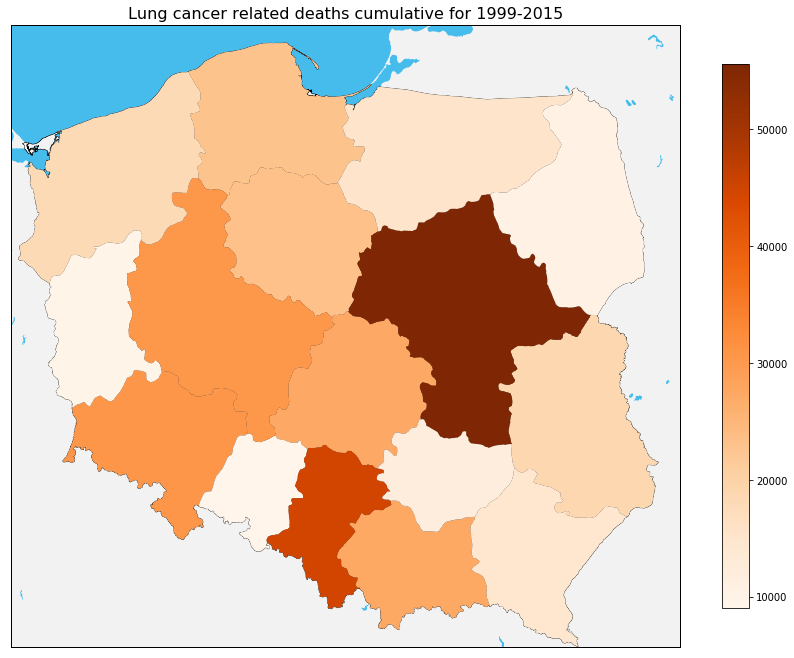

In [28]:
fig, ax = plt.subplots(figsize=(15,25))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=54.5, lon_0=-4.36, # centre of the map
            llcrnrlon=14., llcrnrlat= 49., # edges of the map
            urcrnrlon=24.5, urcrnrlat=55.)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')

path = '../utils/POL_adm1'
shape_file = join(path, 'POL_adm1')
# (num_shapes, mtype, mmin, mmax) = 
m.readshapefile(shape_file, 'areas')

# have to add shape column for each voivoidship
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'area': [area['VARNAME_1'] for area in m.areas_info],
        'shape_num': [area['SHAPENUM'] for area in m.areas_info]
    })

for i, r in df_poly.iterrows():
    df_poly.loc[df_poly['area'] == 'Lódzkie', 'area'] = 'ŁÓDZKIE'.lower().capitalize()
    df_poly.loc[df_poly['area'] == 'Dolnoslaskie', 'area'] = 'DOLNOŚLĄSKIE'.lower().capitalize()
    df_poly.loc[df_poly['area'] == 'Malopolskie', 'area'] = 'MAŁOPOLSKIE'.lower().capitalize()
    df_poly.loc[df_poly['area'] == 'Slaskie', 'area'] = 'ŚLĄSKIE'.lower().capitalize()
    df_poly.loc[df_poly['area'] == 'Swietokrzyskie', 'area'] = 'ŚWIĘTOKRZYSKIE'.lower().capitalize()
    df_poly.loc[df_poly['area'] == 'Warminsko-Mazurskie', 'area'] = 'WARMIŃSKO-MAZURSKIE'.lower().capitalize()
df_poly

for i, r in df_poly.iterrows():
    dfl.loc[dfl['Nazwa'] == r['area'].upper(), 'shapes'] = r['shapes']

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(dfl.shapes, zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(dfl['sum'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(dfl['sum'])
plt.colorbar(mapper, shrink=0.4)
plt.title("Lung cancer related deaths cumulative for 1999-2015",fontsize=16)
m

## The fun part

Since the azbestos dataset TERYT code is missing the 9th digit we have to add it first. We will use TERYT dataset to match the code to the place name.

In [29]:
for i, r in dft.iterrows():
    dfa.loc[dfa['TERYT'] == r['TERYT'][:-1], 'TERYT'] = r['TERYT']
dfa.head()

,Disposed [ton],Inventory [ton],Place Name,TERYT
0,0.0000,414.42221,Bolesławiec,0201011
1,260.8500,1370.09275,Bolesławiec,0201022
2,137.1766,409.70314,Gromadka,0201032
3,2.1780,473.44795,Nowogrodziec,0201043
4,3.3440,375.53764,Osiecznica,0201052


Lastly based on the TERYT now we can match it to the coordinates from the postal code dataset.

In [30]:
for i, r in dfc.iterrows():
    dfa.loc[dfa['Place Name'] == r['Place Name'], 'Latitude'] = r['Latitude']
dfa.head()

,Disposed [ton],Inventory [ton],Place Name,TERYT,Latitude
0,0.0000,414.42221,Bolesławiec,0201011,51.2000
1,260.8500,1370.09275,Bolesławiec,0201022,51.2000
2,137.1766,409.70314,Gromadka,0201032,51.3667
3,2.1780,473.44795,Nowogrodziec,0201043,51.2000
4,3.3440,375.53764,Osiecznica,0201052,51.3333


In [31]:
for i, r in dfc.iterrows():
    dfa.loc[dfa['Place Name'] == r['Place Name'], 'Longitude'] = r['Longitude']
dfa.head()

,Disposed [ton],Inventory [ton],Place Name,TERYT,Latitude,Longitude
0,0.0000,414.42221,Bolesławiec,0201011,51.2000,18.2000
1,260.8500,1370.09275,Bolesławiec,0201022,51.2000,18.2000
2,137.1766,409.70314,Gromadka,0201032,51.3667,15.7500
3,2.1780,473.44795,Nowogrodziec,0201043,51.2000,15.4000
4,3.3440,375.53764,Osiecznica,0201052,51.3333,15.4167


For sanity, check for NaN values:

In [32]:
dfa.loc[dfa['Inventory [ton]'].isnull()]

,Disposed [ton],Inventory [ton],Place Name,TERYT,Latitude,Longitude
2469,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
dfa = dfa.dropna(how='all')
dfa = dfa.reset_index(drop=True)
dfa.loc[dfa['Inventory [ton]'].isnull()]

,Disposed [ton],Inventory [ton],Place Name,TERYT,Latitude,Longitude


In [34]:
dfa.head()

,Disposed [ton],Inventory [ton],Place Name,TERYT,Latitude,Longitude
0,0.0000,414.42221,Bolesławiec,0201011,51.2000,18.2000
1,260.8500,1370.09275,Bolesławiec,0201022,51.2000,18.2000
2,137.1766,409.70314,Gromadka,0201032,51.3667,15.7500
3,2.1780,473.44795,Nowogrodziec,0201043,51.2000,15.4000
4,3.3440,375.53764,Osiecznica,0201052,51.3333,15.4167


In [35]:
csvname = 'asbestos_cleanup_poland.csv'
dfa.to_csv(csvname, encoding='utf-8', index=False)

## Plotly 

In [27]:
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [29]:
print('Shape', dfa.shape)
print('-------------------------')
print('Number of rows', len(dfa))
print('-------------------------')
print('Column headers', dfa.columns)
print('-------------------------')
print('Data types', dfa.dtypes)
print('-------------------------')
print('Index', dfa.index)
print('-------------------------')

Shape (2469, 6)
-------------------------
Number of rows 2469
-------------------------
Column headers Index(['Disposed [ton]', 'Inventory [ton]', 'Place Name', 'TERYT', 'Latitude',
       'Longitude'],
      dtype='object')
-------------------------
Data types Disposed [ton]     float64
Inventory [ton]    float64
Place Name          object
TERYT               object
Latitude           float64
Longitude          float64
dtype: object
-------------------------
Index RangeIndex(start=0, stop=2469, step=1)
-------------------------


In [30]:
import numpy as np
hist, bins = np.histogram(dfa['Inventory [ton]'])
bins = bins.tolist()

In [31]:
print('-------------------------')
print('Count: %s' % hist)
print('-------------------------')
print('Division: %s' % bins)
print('-------------------------')
print('Bin Count: %d' % len(bins))
print('-------------------------')

-------------------------
Count: [2048  363   47    7    1    0    2    0    0    1]
-------------------------
Division: [0.011, 4039.837129, 8079.6632580000005, 12119.489387, 16159.315516, 20199.141645, 24238.967773999997, 28278.793902999998, 32318.620032, 36358.446161, 40398.27229]
-------------------------
Bin Count: 11
-------------------------


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'histogram')

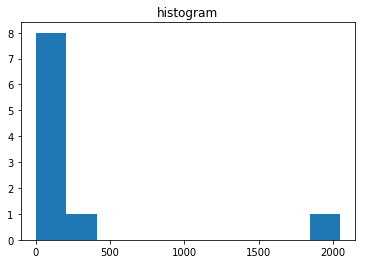

In [33]:
plt.hist(hist, bins = 10) 
plt.title("histogram") 

In [34]:
a = bins[0:5]
b = bins[1:5]
b.append(bins[-1])
limits = list(zip(a, b))

In [35]:
dfa['text'] = dfa['Place Name'] + '<br>Inventory ' + (dfa['Inventory [ton]']).astype(str) +' tons'
colors = ["rgb(0,116,217)","rgb(255,65,54)",
          "rgb(133,20,75)","rgb(255,133,27)","lightgrey",
         'red',
         'green',
         'yellow',
         'blue',
         'magenta',
        'cyan']

In [36]:
cities = []
scale = 100

for i in range(len(limits)):
    lim = limits[i]
    df_sub = dfa[dfa['Inventory [ton]'].between(lim[0],lim[1], inclusive=True)]
    city = dict(
        type = 'scattergeo',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Inventory [ton]']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0:.1f} - {1:.1f}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = dict(
        title = 'Azbestos deposits in Poland<br>(Click legend to toggle traces)',
        showlegend = True,
        autosize=False,
        width=800,
        height=800,
        geo = dict(
            scope='europe',
            resolution = 50,
            projection=dict( type='sinusoidal' ),
            showland = True,
            landcolor = "rgb(217, 217, 217)",
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)",
            lonaxis = dict( range= [ 14.0, 24.5 ] ),
            lataxis = dict( range= [ 49.0, 55.0 ] )
        ),
    )

fig = dict( data=cities, layout=layout )
iplot( fig, validate=False, filename='poland-map-azbestos' )

## Some more plots

### What's the backlog

In [37]:
dft.loc[dft['Place Type'] == 'województwo']

,Place Name,Place Type,TERYT
0,DOLNOŚLĄSKIE,województwo,0200000
314,KUJAWSKO-POMORSKIE,województwo,0400000
552,LUBELSKIE,województwo,0600000
834,LUBUSKIE,województwo,0800000
998,ŁÓDZKIE,województwo,1000000
1255,MAŁOPOLSKIE,województwo,1200000
1556,MAZOWIECKIE,województwo,1400000
2031,OPOLSKIE,województwo,1600000
2179,PODKARPACKIE,województwo,1800000
2431,PODLASKIE,województwo,2000000


In [38]:
void = []
dfn = dft.loc[dft['Place Type'] == 'województwo']
for i, r in dfn.iterrows():
    void.append(r['TERYT'][:2])
void

['02',
 '04',
 '06',
 '08',
 '10',
 '12',
 '14',
 '16',
 '18',
 '20',
 '22',
 '24',
 '26',
 '28',
 '30',
 '32']

In [39]:
dfn.head()

,Place Name,Place Type,TERYT
0,DOLNOŚLĄSKIE,województwo,0200000
314,KUJAWSKO-POMORSKIE,województwo,0400000
552,LUBELSKIE,województwo,0600000
834,LUBUSKIE,województwo,0800000
998,ŁÓDZKIE,województwo,1000000


In [40]:
d = []
for w in void:
    x = dfa.loc[dfa['TERYT'].str.contains(w)]['Inventory [ton]'].sum()
    z = dfa.loc[dfa['TERYT'].str.contains(w)]['Disposed [ton]'].sum()
    y = x - z
    d.append({'Disposed': z, 
              'Backlog': y,
             'Kod': w})
df = pd.DataFrame(d)

for i, r in dfn.iterrows():
    df.loc[df['Kod'] == r['TERYT'][:2], 'Name'] = r['Place Name'].lower().capitalize()

df.head()

,Backlog,Disposed,Kod,Name
0,1.224391e+06,146365.74979,02,Dolnośląskie
1,1.208859e+06,95144.77804,04,Kujawsko-pomorskie
2,1.484666e+06,102490.28486,06,Lubelskie
3,5.663944e+05,54708.02151,08,Lubuskie
4,1.351643e+06,90876.31257,10,Łódzkie


Text(0.5,1,'Azbestos in Poland')

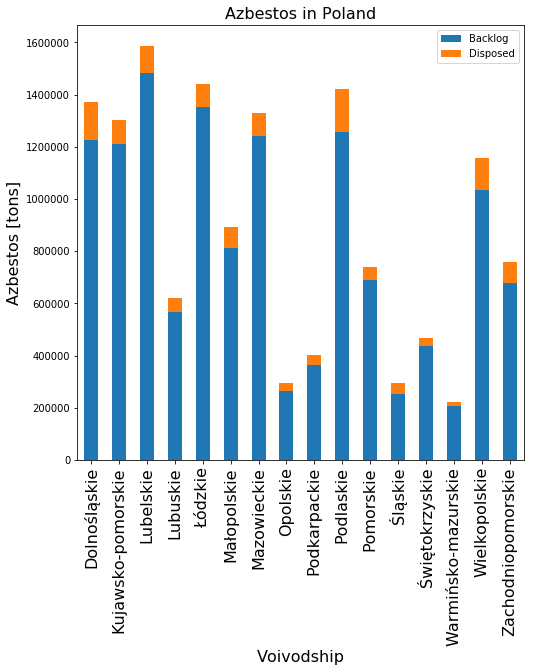

In [41]:
my_plot = df[['Backlog','Disposed']].plot(kind='bar', 
                                               stacked=True,figsize=(8,8));
my_plot.set_xlabel("Voivodship", fontsize=16);
my_plot.set_ylabel("Azbestos [tons]", fontsize=16);
my_plot.set_xticklabels(df['Name'], rotation=90, fontsize=16);
my_plot.set_title("Azbestos in Poland",fontsize=16)